In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [2]:
# Q11

In [3]:
up_side = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
left_side = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
right_side = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
down_side = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
out = -2

def transition_prob(curS, nextS, move, w):
    # move 0 -> left, 1 -> up, 2 -> right, 3 -> down
    
    left = curS - 10
    right = curS + 10
    up = curS - 1
    down = curS + 1
    if curS in up_side:
        up = out
    if curS in down_side:
        down = out
    if curS in right_side:
        right = out
    if curS in left_side:
        left = out
    
    if nextS == left:
        if move == 0:
            return 1 - 0.75*w
        else:
            return 0.25*w
    elif nextS == up:
        if move == 1:
            return 1 - 0.75*w
        else:
            return 0.25*w
    elif nextS == right:
        if move == 2:
            return 1 - 0.75*w
        else:
            return 0.25*w
    elif nextS == down:
        if move == 3:
            return 1 - 0.75*w
        else:
            return 0.25*w
    elif nextS == curS:
        record = 0
        if left == out:
            #print("left out")
            if move == 0:
                record += (1 - 0.75*w)
            else:
                record += 0.25*w
        if up == out:
            #print("up out")
            if move == 1:
                record += (1 - 0.75*w)
            else:
                record += 0.25*w
        if right == out:
            #print("right out")
            if move == 2:
                record += (1 - 0.75*w)
            else:
                record += 0.25*w
        if down == out:
            #print("down out")
            if move == 3:
                record += (1 - 0.75*w)
            else:
                record += 0.25*w
        return record
    else:
        return 0


actions = [-10, -1, 10, 1]
def compute(curS, move, w, gamma, reward, values):
    left = curS + actions[0]
    up = curS + actions[1]
    right = curS + actions[2]
    down = curS + actions[3]
    neighbors = [left, up, right, down, curS]
    result = 0
    for neigh in neighbors:
        if neigh < 0 or neigh > 99 or (curS % 10 == 0 and neigh % 10 == 9) or (curS % 10 == 9 and neigh % 10 == 0):
            continue
        result += transition_prob(curS, neigh, move, w) * (reward[neigh] + gamma * values[neigh])
    return result


def value_iteration(values, w, gamma, reward, threshold):
    
    for state in range(100):
        values[state] = 0
    
    delta = float('inf')
    cnt = 0
    while delta > threshold:
        #print(delta)
        cnt += 1
        delta = 0
        temp = values[:]
        for state in range(100):
            v = values[state]
            values[state] = max(compute(state, 0, w, gamma, reward, temp),
                               compute(state, 1, w, gamma, reward, temp),
                               compute(state, 2, w, gamma, reward, temp),
                               compute(state, 3, w, gamma, reward, temp))
            delta = max(delta, abs(v - values[state]))
    return [values, cnt]

In [4]:
def P_of_move(direction, w):
    move = -1
    if direction == "left":
        move = 0
    elif direction == "up":
        move = 1
    elif direction == "right":
        move = 2
    elif direction == "down":
        move = 3
    else:
        raise Exception("Move is invalid")
    N = 10
    s = N*N
    res = np.zeros(s * s).reshape(s, s)
    for curS in range(s):
        for nextS in range(s):
            res[curS][nextS] = transition_prob(curS, nextS, move, w)
    
    return res

In [5]:
def cal_c_D_b(exp_actions, trans_probs, lambd, rmax, gamma):
    P_exp = []
    P_ags = []
    P_ags.append([])
    P_ags.append([])
    P_ags.append([])
    
    # get Pa1, Pa*3
    for state in range(100):
        exp_action = exp_actions[state]
        agent = 0
        for action in range(4):
            if action == exp_action:
                P_exp.append(trans_probs[action][state])
            else:
                P_ags[agent].append(trans_probs[action][state])
                agent += 1
    
    I = np.eye(100)
    zero = np.zeros(100 * 100).reshape(100, 100)
    D = np.concatenate((zero, zero, zero, zero))
    D = np.concatenate((D, np.concatenate((-I, -I, zero, zero)), np.concatenate((I, -I, I, -I))), 1)
    
    for pa in P_ags:
        
        temp = np.dot((np.array(pa) - np.array(P_exp)), 
                      np.linalg.inv(np.eye(100) - gamma * np.array(P_exp)))
        row1 = np.concatenate((I, zero, temp), axis = 1)
        row2 = np.concatenate((zero, zero, temp), axis = 1)
        temp = np.concatenate((row1, row2), axis = 0)
        D = np.concatenate((temp, D))
    
    
    c1 = np.array([1. for _ in range(100)])
    c2 = np.array([-lambd for _ in range(100)])
    c3 = np.array([0.0 for _ in range(100)])
    c = np.concatenate((c1, c2, c3), axis=0)
    c = -c
    
    b1 = np.array([0.0 for _ in range(800)])
    b2 = np.array([rmax for _ in range(200)])
    b = np.concatenate((b1, b2), axis = 0)
    
    return c, D, b
    

In [6]:
def learn_reward(c, D, b):
    DD = matrix(D)
    bb = matrix(b)
    cc = matrix(c)
    solvers.options['show_progress'] = False
    sol = solvers.lp(cc, DD, bb)
    return sol['x'][-100:]

In [7]:
def lambd_vs_acc(exp_action, trans_probs, rmax, gamma, w, thres):
    acc_list = []
    lam_list = []
    lam = 0
    for i in range(501):
        c, D, b = cal_c_D_b(exp_action, trans_probs, lam, rmax, gamma)
        rew = np.array(learn_reward(c, D, b))
        val = [0 for _ in range(100)]
        [value_f, count] = value_iteration(val, w, gamma, rew, thres)
        agent_action = [0 for _ in range(100)]
        for state in range(100):
            agent_action[state] = np.argmax([compute(state, 0, w, gamma, rew, value_f),
                                            compute(state, 1, w, gamma, rew, value_f),
                                            compute(state, 2, w, gamma, rew, value_f),
                                            compute(state, 3, w, gamma, rew, value_f)])
        
        cnt = 0
        for i in range(len(exp_action)):
            if exp_action[i] == agent_action[i]:
                cnt += 1
        
        acc = cnt / len(agent_action)
        
        print("lambda: " + str(lam) + "  acc: " + str(acc))
        lam_list.append(lam)
        acc_list.append(acc)
        lam += 0.01
    return lam_list, acc_list

In [8]:
length = 10
reward1 = [[0]*length for _ in range(length)]
reward1[9][9] = 1
reward1[2][5:7] = [-10, -10]
reward1[3][5:7] = [-10, -10]
reward1[4][1:3] = [-10, -10]
reward1[5][1:3] = [-10, -10]
reward1[8][2:4] = [-10, -10]
reward1[9][2:4] = [-10, -10]

values = [0 for _ in range(100)]
thres = 0.01
w = 0.1
gamma = 0.8
rmax = 1

reward = []
reward1_t = np.array(reward1).transpose()
for lines in reward1_t:
    reward += list(lines)
    
exp_action = [0 for _ in range(100)]
[values_final, cnt] = value_iteration(values, w, gamma, reward, thres)

for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward, values_final),
                            compute(state, 1, w, gamma, reward, values_final),
                            compute(state, 2, w, gamma, reward, values_final),
                            compute(state, 3, w, gamma, reward, values_final)])


In [9]:
Prob_moves = []
Prob_moves.append(P_of_move("left", w))
Prob_moves.append(P_of_move("up", w))
Prob_moves.append(P_of_move("right", w))
Prob_moves.append(P_of_move("down", w))

In [10]:
lams, accs = lambd_vs_acc(exp_action, Prob_moves, rmax, gamma, w, thres)

lambda: 0  acc: 0.78
lambda: 0.01  acc: 0.76
lambda: 0.02  acc: 0.74
lambda: 0.03  acc: 0.74
lambda: 0.04  acc: 0.74
lambda: 0.05  acc: 0.74
lambda: 0.060000000000000005  acc: 0.74
lambda: 0.07  acc: 0.75
lambda: 0.08  acc: 0.75
lambda: 0.09  acc: 0.76
lambda: 0.09999999999999999  acc: 0.76
lambda: 0.10999999999999999  acc: 0.76
lambda: 0.11999999999999998  acc: 0.76
lambda: 0.12999999999999998  acc: 0.76
lambda: 0.13999999999999999  acc: 0.76
lambda: 0.15  acc: 0.76
lambda: 0.16  acc: 0.76
lambda: 0.17  acc: 0.77
lambda: 0.18000000000000002  acc: 0.77
lambda: 0.19000000000000003  acc: 0.77
lambda: 0.20000000000000004  acc: 0.77
lambda: 0.21000000000000005  acc: 0.77
lambda: 0.22000000000000006  acc: 0.77
lambda: 0.23000000000000007  acc: 0.78
lambda: 0.24000000000000007  acc: 0.78
lambda: 0.25000000000000006  acc: 0.78
lambda: 0.26000000000000006  acc: 0.78
lambda: 0.2700000000000001  acc: 0.78
lambda: 0.2800000000000001  acc: 0.77
lambda: 0.2900000000000001  acc: 0.77
lambda: 0.30000

lambda: 2.2199999999999966  acc: 0.88
lambda: 2.2299999999999964  acc: 0.88
lambda: 2.239999999999996  acc: 0.88
lambda: 2.249999999999996  acc: 0.88
lambda: 2.259999999999996  acc: 0.88
lambda: 2.2699999999999956  acc: 0.88
lambda: 2.2799999999999954  acc: 0.88
lambda: 2.289999999999995  acc: 0.88
lambda: 2.299999999999995  acc: 0.88
lambda: 2.3099999999999947  acc: 0.88
lambda: 2.3199999999999945  acc: 0.88
lambda: 2.3299999999999943  acc: 0.88
lambda: 2.339999999999994  acc: 0.88
lambda: 2.349999999999994  acc: 0.88
lambda: 2.3599999999999937  acc: 0.88
lambda: 2.3699999999999934  acc: 0.88
lambda: 2.3799999999999932  acc: 0.88
lambda: 2.389999999999993  acc: 0.88
lambda: 2.399999999999993  acc: 0.88
lambda: 2.4099999999999926  acc: 0.88
lambda: 2.4199999999999924  acc: 0.88
lambda: 2.429999999999992  acc: 0.88
lambda: 2.439999999999992  acc: 0.88
lambda: 2.4499999999999917  acc: 0.88
lambda: 2.4599999999999915  acc: 0.88
lambda: 2.4699999999999913  acc: 0.85
lambda: 2.4799999999999

lambda: 4.41999999999995  acc: 0.49
lambda: 4.42999999999995  acc: 0.49
lambda: 4.43999999999995  acc: 0.49
lambda: 4.4499999999999496  acc: 0.5
lambda: 4.459999999999949  acc: 0.5
lambda: 4.469999999999949  acc: 0.51
lambda: 4.479999999999949  acc: 0.51
lambda: 4.489999999999949  acc: 0.51
lambda: 4.4999999999999485  acc: 0.5
lambda: 4.509999999999948  acc: 0.49
lambda: 4.519999999999948  acc: 0.48
lambda: 4.529999999999948  acc: 0.49
lambda: 4.539999999999948  acc: 0.5
lambda: 4.549999999999947  acc: 0.49
lambda: 4.559999999999947  acc: 0.5
lambda: 4.569999999999947  acc: 0.5
lambda: 4.579999999999947  acc: 0.5
lambda: 4.589999999999947  acc: 0.5
lambda: 4.599999999999946  acc: 0.5
lambda: 4.609999999999946  acc: 0.5
lambda: 4.619999999999946  acc: 0.5
lambda: 4.629999999999946  acc: 0.49
lambda: 4.6399999999999455  acc: 0.49
lambda: 4.649999999999945  acc: 0.49
lambda: 4.659999999999945  acc: 0.49
lambda: 4.669999999999945  acc: 0.49
lambda: 4.679999999999945  acc: 0.49
lambda: 4.68

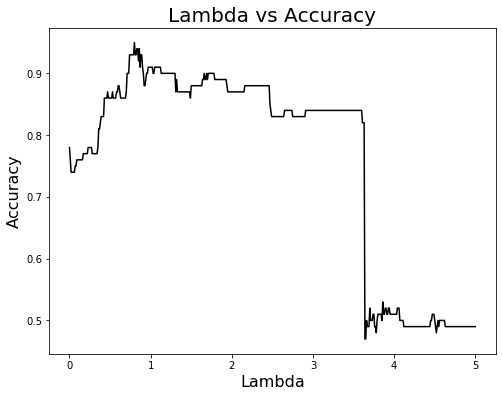

In [11]:
plt.figure(figsize=(8,6))
plt.xlabel('Lambda', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Lambda vs Accuracy', fontsize=20)
plt.plot(lams, accs, color="black")
plt.show()

In [12]:
# Q12
idx = np.argmax(accs)
lam_max = lams[idx]
print(lam_max)
print(accs[idx])

0.8000000000000005
0.95


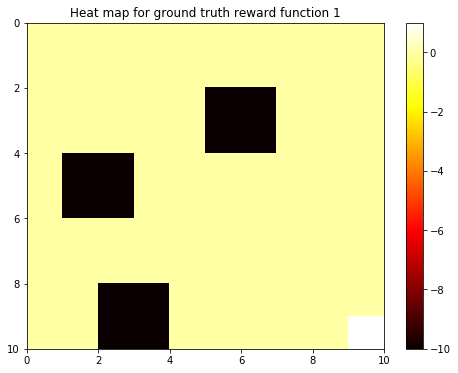

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 -10 -10   0   0   0   0]
 [  0   0   0   0 -10 -10   0   0 -10 -10]
 [  0   0   0   0   0   0   0   0 -10 -10]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 -10 -10   0   0   0   0   0   0]
 [  0   0 -10 -10   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1]]


In [13]:
# Q13

plt.figure(figsize=(8,6))
plt.title("Heat map for ground truth reward function 1")
plt.pcolor(reward1, cmap = 'hot')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
print(np.array(reward1).reshape(10,10).transpose())

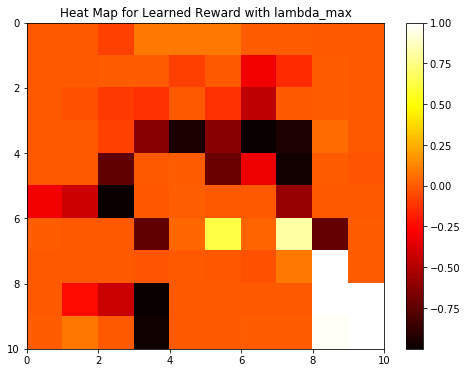

[[-6.67689319e-04 -1.50914696e-03 -7.58033927e-02  8.79408483e-02
   8.94707104e-02  8.79136001e-02  2.70670126e-08  1.98468853e-07
   1.04892945e-09 -7.62009135e-09]
 [-6.63619638e-09  1.61925911e-09  4.00854798e-09  2.20849678e-08
  -8.13693436e-02  9.94662408e-10 -3.07321725e-01 -1.44740398e-01
   5.26707346e-09 -4.11350717e-09]
 [-3.89074449e-09 -3.04574712e-02 -9.90638518e-02 -1.30666025e-01
  -4.64001842e-09 -1.32665960e-01 -4.61963424e-01 -6.18406513e-08
   1.96244611e-08 -2.67084695e-09]
 [-7.47232193e-09 -4.83878531e-09 -7.48078335e-02 -6.23176544e-01
  -9.53072143e-01 -6.24114131e-01 -9.99999989e-01 -9.44770102e-01
   5.33918860e-02 -1.95580129e-09]
 [-7.87507308e-09 -1.03941752e-08 -7.41472042e-01 -3.05379994e-08
   2.30574296e-08 -7.11472975e-01 -3.15664070e-01 -9.73084664e-01
   2.84922161e-09 -1.91745492e-02]
 [-3.09605632e-01 -4.14417863e-01 -9.99999770e-01 -1.01058792e-02
   9.99647429e-03 -1.35010823e-08 -1.61379470e-08 -5.81990844e-01
  -9.25793674e-09 -1.30306318e-08

In [14]:
c_m, D_m, b_m = cal_c_D_b(exp_action, Prob_moves, lam_max, rmax, gamma)
reward_m = np.array(learn_reward(c_m, D_m, b_m))
reward_m_mat = reward_m.reshape(10, 10).transpose()

plt.figure(figsize=(8,6))
plt.pcolor(reward_m_mat, cmap ='hot')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat Map for Learned Reward with lambda_max")
plt.show()
print(reward_m_mat)

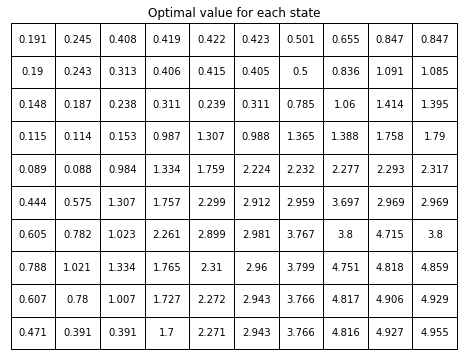

In [15]:
# Q14
w = 0.1
gamma = 0.8
thres = 0.01
values = [0 for _ in range(100)]

[values_final, cnt] = value_iteration(values, w, gamma, reward_m, thres)
plt.figure(figsize=(8,6))
g1 = np.round(values_final, decimals=3).reshape(10, 10).transpose()

tb = plt.table(cellText=g1, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("Optimal value for each state")
plt.show()

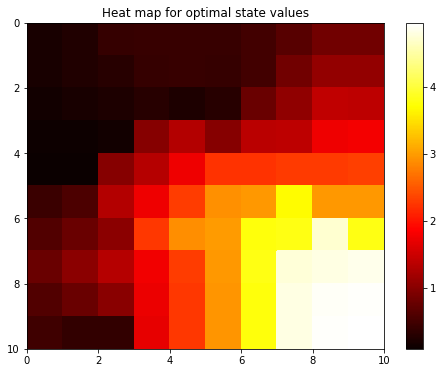

In [16]:
plt.figure(figsize=(8,6))
plt.title("Heat map for optimal state values")
plt.pcolor(g1, cmap = 'hot')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

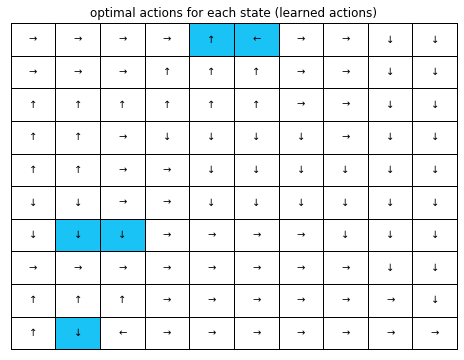

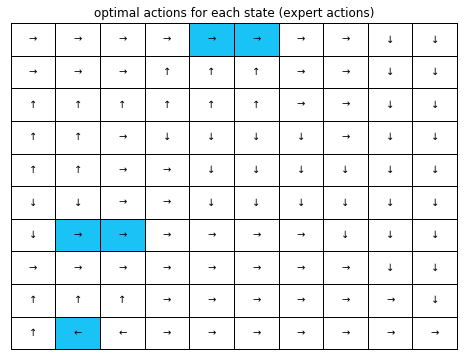

In [17]:
# Q16

acts = [0 for _ in range(100)]
acts_arrow = [0 for _ in range(100)]

exp_acts = exp_action
exp_acts_arrow = [0 for _ in range(100)]
colors = ["" for _ in range(100)]

arrows = ['\u2190', '\u2191', '\u2192', '\u2193']
for state in range(100):
    acts[state] = np.argmax([compute(state, 0, w, gamma, reward_m, values_final),
                            compute(state, 1, w, gamma, reward_m, values_final),
                            compute(state, 2, w, gamma, reward_m, values_final),
                            compute(state, 3, w, gamma, reward_m, values_final)])
    if exp_acts[state] == acts[state]:
        colors[state] = "w"
    else:
        colors[state] = "#1ac3f5"
        
    exp_acts_arrow[state] = arrows[exp_acts[state]]
    acts_arrow[state] = arrows[acts[state]]

col = np.array(colors).reshape(10, 10).transpose()

a1 = np.array(acts_arrow).reshape(10, 10).transpose()
plt.figure(figsize = (8, 6))
plt.title("optimal actions for each state (learned actions)")
tb = plt.table(cellText = a1, loc = (0, 0), cellLoc = 'center', cellColours = col)
tc = tb.properties()['child_artists']

for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

exp1 = np.array(exp_acts_arrow).reshape(10, 10).transpose()
plt.figure(figsize = (8, 6))
plt.title("optimal actions for each state (expert actions)")
tb = plt.table(cellText = exp1, loc = (0, 0), cellLoc = 'center', cellColours = col)
tc = tb.properties()['child_artists']

for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [18]:
# Q18
length = 10
reward2 = [[0] * length for _ in range(length)]
reward2[9][9] = 10

reward2[1][4:7] = [-100] * 3
reward2[2][4] = -100
reward2[2][6] = -100
reward2[3][4] = -100
reward2[3][6:9] = [-100] * 3
reward2[4][4] = -100
reward2[4][8] = -100
reward2[5][4] = -100
reward2[5][8] = -100
reward2[6][4] = -100
reward2[6][8] = -100
reward2[7][6:9] = [-100] * 3
reward2[8][6] = -100

values = [0 for _ in range(100)]
thres = 0.01
w = 0.1
gamma = 0.8
rmax = 100

reward = []
reward2_t = np.array(reward2).transpose()
for lines in reward2_t:
    reward += list(lines)
    
exp_action = [0 for _ in range(100)]
[values_final, cnt] = value_iteration(values, w, gamma, reward, thres)

for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward, values_final),
                            compute(state, 1, w, gamma, reward, values_final),
                            compute(state, 2, w, gamma, reward, values_final),
                            compute(state, 3, w, gamma, reward, values_final)])

In [19]:
Prob_moves = []
Prob_moves.append(P_of_move("left", w))
Prob_moves.append(P_of_move("up", w))
Prob_moves.append(P_of_move("right", w))
Prob_moves.append(P_of_move("down", w))

In [20]:
lams2, accs2 = lambd_vs_acc(exp_action, Prob_moves, rmax, gamma, w, thres)

lambda: 0  acc: 0.82
lambda: 0.01  acc: 0.8
lambda: 0.02  acc: 0.78
lambda: 0.03  acc: 0.79
lambda: 0.04  acc: 0.78
lambda: 0.05  acc: 0.78
lambda: 0.060000000000000005  acc: 0.8
lambda: 0.07  acc: 0.84
lambda: 0.08  acc: 0.83
lambda: 0.09  acc: 0.83
lambda: 0.09999999999999999  acc: 0.84
lambda: 0.10999999999999999  acc: 0.83
lambda: 0.11999999999999998  acc: 0.81
lambda: 0.12999999999999998  acc: 0.81
lambda: 0.13999999999999999  acc: 0.79
lambda: 0.15  acc: 0.79
lambda: 0.16  acc: 0.81
lambda: 0.17  acc: 0.81
lambda: 0.18000000000000002  acc: 0.82
lambda: 0.19000000000000003  acc: 0.82
lambda: 0.20000000000000004  acc: 0.83
lambda: 0.21000000000000005  acc: 0.82
lambda: 0.22000000000000006  acc: 0.83
lambda: 0.23000000000000007  acc: 0.83
lambda: 0.24000000000000007  acc: 0.83
lambda: 0.25000000000000006  acc: 0.89
lambda: 0.26000000000000006  acc: 0.89
lambda: 0.2700000000000001  acc: 0.88
lambda: 0.2800000000000001  acc: 0.88
lambda: 0.2900000000000001  acc: 0.88
lambda: 0.3000000

lambda: 2.2199999999999966  acc: 0.91
lambda: 2.2299999999999964  acc: 0.91
lambda: 2.239999999999996  acc: 0.91
lambda: 2.249999999999996  acc: 0.9
lambda: 2.259999999999996  acc: 0.9
lambda: 2.2699999999999956  acc: 0.9
lambda: 2.2799999999999954  acc: 0.9
lambda: 2.289999999999995  acc: 0.91
lambda: 2.299999999999995  acc: 0.91
lambda: 2.3099999999999947  acc: 0.89
lambda: 2.3199999999999945  acc: 0.91
lambda: 2.3299999999999943  acc: 0.91
lambda: 2.339999999999994  acc: 0.89
lambda: 2.349999999999994  acc: 0.9
lambda: 2.3599999999999937  acc: 0.91
lambda: 2.3699999999999934  acc: 0.77
lambda: 2.3799999999999932  acc: 0.77
lambda: 2.389999999999993  acc: 0.79
lambda: 2.399999999999993  acc: 0.78
lambda: 2.4099999999999926  acc: 0.78
lambda: 2.4199999999999924  acc: 0.58
lambda: 2.429999999999992  acc: 0.59
lambda: 2.439999999999992  acc: 0.59
lambda: 2.4499999999999917  acc: 0.59
lambda: 2.4599999999999915  acc: 0.56
lambda: 2.4699999999999913  acc: 0.56
lambda: 2.479999999999991  a

lambda: 4.4499999999999496  acc: 0.6
lambda: 4.459999999999949  acc: 0.6
lambda: 4.469999999999949  acc: 0.6
lambda: 4.479999999999949  acc: 0.6
lambda: 4.489999999999949  acc: 0.6
lambda: 4.4999999999999485  acc: 0.6
lambda: 4.509999999999948  acc: 0.6
lambda: 4.519999999999948  acc: 0.61
lambda: 4.529999999999948  acc: 0.61
lambda: 4.539999999999948  acc: 0.61
lambda: 4.549999999999947  acc: 0.61
lambda: 4.559999999999947  acc: 0.61
lambda: 4.569999999999947  acc: 0.61
lambda: 4.579999999999947  acc: 0.61
lambda: 4.589999999999947  acc: 0.61
lambda: 4.599999999999946  acc: 0.61
lambda: 4.609999999999946  acc: 0.61
lambda: 4.619999999999946  acc: 0.61
lambda: 4.629999999999946  acc: 0.61
lambda: 4.6399999999999455  acc: 0.61
lambda: 4.649999999999945  acc: 0.61
lambda: 4.659999999999945  acc: 0.61
lambda: 4.669999999999945  acc: 0.6
lambda: 4.679999999999945  acc: 0.6
lambda: 4.689999999999944  acc: 0.6
lambda: 4.699999999999944  acc: 0.61
lambda: 4.709999999999944  acc: 0.61
lambda: 

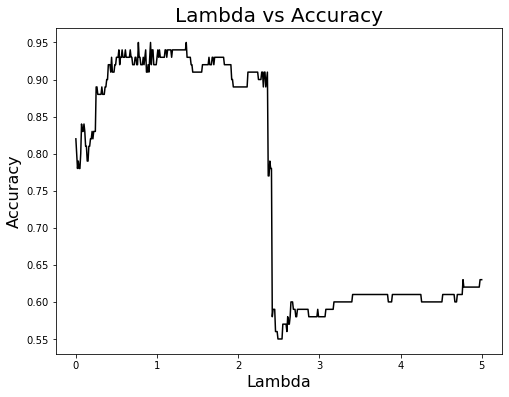

In [21]:
plt.figure(figsize=(8,6))
plt.xlabel('Lambda', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Lambda vs Accuracy', fontsize=20)
plt.plot(lams2, accs2, color="black")
plt.show()

In [28]:
# Q19
idx = np.argmax(accs2)
lam_max = lams2[idx]
print(lam_max)
print(accs2[idx])
lam_max=0.77

0.7700000000000005
0.95


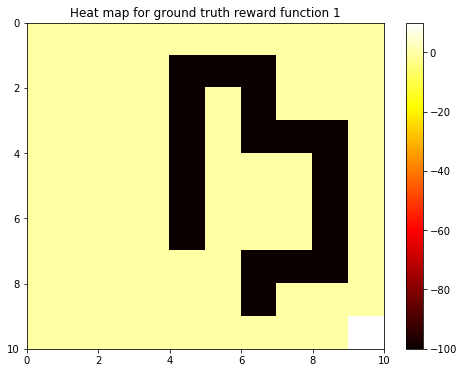

In [29]:
# Q20
plt.figure(figsize=(8,6))
plt.title("Heat map for ground truth reward function 1")
plt.pcolor(reward2, cmap = 'hot')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

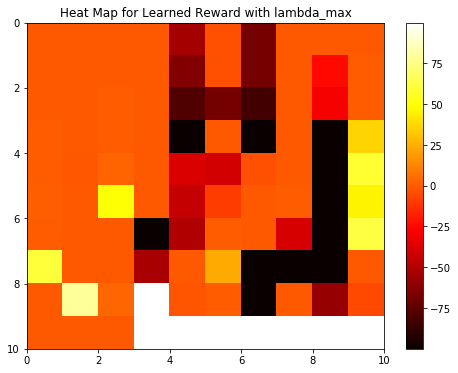

In [30]:
c_m, D_m, b_m = cal_c_D_b(exp_action, Prob_moves, lam_max, rmax, gamma)
reward_m = np.array(learn_reward(c_m, D_m, b_m))
reward_m_mat = reward_m.reshape(10, 10).transpose()

plt.figure(figsize=(8,6))
plt.pcolor(reward_m_mat, cmap = 'hot')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat Map for Learned Reward with lambda_max")
plt.show()

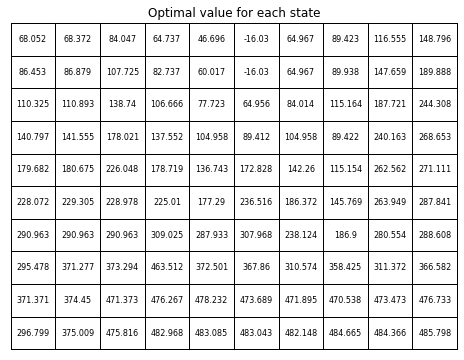

In [31]:
# Q21
w = 0.1
gamma = 0.8
thres = 0.01
values = [0 for _ in range(100)]

[values_final, cnt] = value_iteration(values, w, gamma, reward_m, thres)
plt.figure(figsize=(8,6))
g1 = np.round(values_final, decimals=3).reshape(10, 10).transpose()

tb = plt.table(cellText=g1, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("Optimal value for each state")
plt.show()

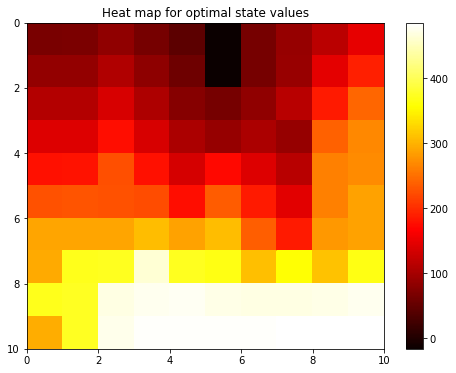

In [32]:
plt.figure(figsize=(8,6))
plt.title("Heat map for optimal state values")
plt.pcolor(g1, cmap = 'hot')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

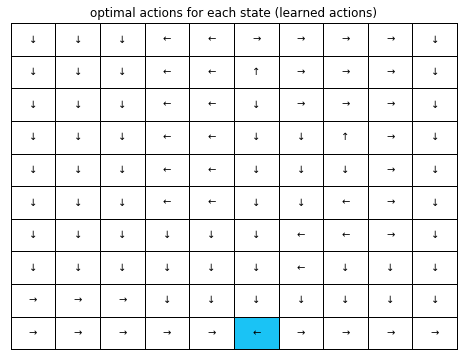

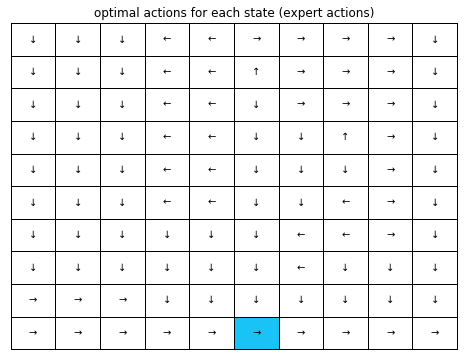

In [36]:
# Q23
acts = [0 for _ in range(100)]
acts_arrow = [0 for _ in range(100)]

exp_acts = exp_action
exp_acts_arrow = [0 for _ in range(100)]
colors = ["" for _ in range(100)]

arrows = ['\u2190', '\u2191', '\u2192', '\u2193']
for state in range(100):
    acts[state] = np.argmax([compute(state, 0, w, gamma, reward_m, values_final),
                            compute(state, 1, w, gamma, reward_m, values_final),
                            compute(state, 2, w, gamma, reward_m, values_final),
                            compute(state, 3, w, gamma, reward_m, values_final)])
    #apply modification 
        # if the state is at the edge
    if (state+1)%10==0 and acts[state]==3:
                        acts[state]=np.argmax([
                                   compute(state,0,w,gamma,reward,values_final),
                                   compute(state,1,w,gamma,reward,values_final),
                                   compute(state,2,w,gamma,reward,values_final)])
    if (state+10)>=100 and acts[state]==2 and state!=99:
                        acts[state]=np.argmax([
                                   compute(state,0,w,gamma,reward,values_final),
                                   compute(state,1,w,gamma,reward,values_final),
                                    -10000,
                                   compute(state,3,w,gamma,reward,values_final)])
                
            
    if exp_acts[state] == acts[state]:
        colors[state] = "w"
    else:
        colors[state] = "#1ac3f5"
        
    exp_acts_arrow[state] = arrows[exp_acts[state]]
    acts_arrow[state] = arrows[acts[state]]

col = np.array(colors).reshape(10, 10).transpose()

a1 = np.array(acts_arrow).reshape(10, 10).transpose()
plt.figure(figsize = (8, 6))
plt.title("optimal actions for each state (learned actions)")
tb = plt.table(cellText = a1, loc = (0, 0), cellLoc = 'center', cellColours = col)
tc = tb.properties()['child_artists']

for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

exp1 = np.array(exp_acts_arrow).reshape(10, 10).transpose()
plt.figure(figsize = (8, 6))
plt.title("optimal actions for each state (expert actions)")
tb = plt.table(cellText = exp1, loc = (0, 0), cellLoc = 'center', cellColours = col)
tc = tb.properties()['child_artists']

for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()